## LSSTC AGN Data Challenge Submission
**By:** Weixiang Yu
<br>
**Summary:**
The aim for this submission is to explore how well we can classify sources into three classes: 'Qso/Agn', 'Gal' and 'Star' using easy to compute light curves statistics, optical color, astrometry (proper motion) and density maps created using light curves. The so called density map is essentially a 2D distribution of variability power in the timescale and magnitude space. This format of expressing variability information was first introduced in [Mahabal+17](https://arxiv.org/pdf/1709.06257.pdf), the actual algorithm used here to generate the density maps is a modified version of that shown in that paper. I would also like to explore the performance of the trained model on objects with less ideal data quality, primarily those with less than 30 epochs in their light curves where model fitting (e.g., using a damped random walk, which has shown promise) becomes expensive and unreliable.

##### **Features Utilized**
- Density Maps (pre-computed from light curves)
- Simple light curves statistics from the `lcNonPeriodic` category, specifically with index, 9, 13, 15, 19, 20, 22, 25, 26. See [here](https://github.com/RichardsGroup/AGN_DataChallenge/blob/main/docs/lc_feats.yml) for the actual variability metric corresponding to each index.
- Five optical colors (`stdColor[0-4]`)
- Proper motion (not all from Gaia) 

##### **How to reproduce**
This notebook doesn't require GPU to run. The density maps have been generated ahead of time and are stored in the shared volume at `/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Yu_dm`.
- __Compute Image__: SciServer Essential 2.0
- __Conda environment__: py38
- __Additional pacakages__: pyarrow, h5py

##### **Note on Data Requirement**
I performed a set cleaning of the object table before training/testing the ML model, which are:
- Must have all `u-g`, `g-r`, `r-i` and `z-i` colors. Objects without them are most likely to be too faint thus producing negative fluxes.
- Must have the most basic light curve features (e.g., standard deviation) computed. This cut is equivalent to requesting the associated light curves to have more than 5 data points.
- Must have proper motion measurements. 

##### **Main Contents**
This notebook will be split into the following sections:
1. Prepare dataset and show a couple selected density maps
2. Train/Test on a subset with less than 30 epochs in their r-band light curves
3. Train/Test on a random subset (20%) of those meeting the above three cuts
4. Show how to test on the blinded dataset using the model trained on the entire 
labeled dataset. 

In [1]:
# common modules
import pandas as pd
import numpy as np
import os, sys
from collections import Counter
import h5py

# TensorFlow & sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')

# dm folder & DC folder
dm_dir = '/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Yu_dm'
data_dir = "/home/idies/workspace/Temporary/ywx649999311/LSST_AGN/Class_Training/DC/"

### 1 Prepare Dataset

#### 1.1 Import object table and clean up

In [2]:
# import object table
object_df = pd.read_parquet(os.path.join(data_dir, 'ObjectTable.parquet'))

# select the objects that have time domain data
lc_cols = [col for col in object_df.columns if 'Periodic' in col]
td_objects = object_df.dropna(subset=lc_cols, how='all').copy()

# require having proper motion and the first four color
color_cols = [col for col in object_df.columns 
              if ('stdColor' in col) & ('Err' not in col) & ('4' not in col)]
td_objects = td_objects.dropna(subset=['psPm_ra', 'psPm_dec']+color_cols, 
                               how='any')

# require only those having a label in ['Qso', 'Agn', 'Gal', 'Star']
td_objects = td_objects[td_objects['class'].isin(
    ['Qso', 'Agn', 'Gal', 'Star'])].copy()

print(f'Total number of useable objects: {td_objects.shape[0]}')

Total number of useable objects: 151937


In [3]:
td_objects.groupby('class').count()

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,...,lcNonPeriodic[27]_u,lcNonPeriodic[27]_g,lcNonPeriodic[27]_r,lcNonPeriodic[27]_i,lcNonPeriodic[27]_z,lcNonPeriodic[28]_u,lcNonPeriodic[28]_g,lcNonPeriodic[28]_r,lcNonPeriodic[28]_i,lcNonPeriodic[28]_z
class,,,,,,,,,,,,,,,,,,,,,
Agn,286,286,286,286,8,286,286,286,286,286,...,285,285,285,285,285,285,285,285,285,285
Gal,52428,52428,52428,52428,88,52428,52428,52428,52428,52428,...,50619,50618,50619,50617,50618,50619,50618,50619,50617,50618
Qso,31622,31622,31622,31622,11635,31622,31622,31622,31622,31622,...,31563,31562,31563,31563,31563,31563,31562,31563,31563,31563
Star,67601,67601,67601,67601,65309,67601,67601,67601,67601,67601,...,67564,67564,67562,67563,67565,67564,67564,67562,67563,67565


#### 1.2 Import ForcedSource table and compute N epochs in r-band

In [3]:
fs_df = pd.read_parquet(os.path.join(data_dir, 'ForcedSourceTable.parquet'))

# groupby forcedsource table by object_id
fs_gp = fs_df.groupby(['objectId'])

# get only r band df and gp
fs_df_r = fs_df[fs_df['filter'] == 2]
fs_gp_r = fs_df_r.groupby(['objectId'])

# compute and assign the number epoch in r band
lcN_r = fs_gp_r.size()
lcN_r.name = 'lcN_r'

In [4]:
# merge with object table
td_objects = td_objects.join(lcN_r, how='left')
td_objects.head(2)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,...,lcNonPeriodic[27]_g,lcNonPeriodic[27]_r,lcNonPeriodic[27]_i,lcNonPeriodic[27]_z,lcNonPeriodic[28]_u,lcNonPeriodic[28]_g,lcNonPeriodic[28]_r,lcNonPeriodic[28]_i,lcNonPeriodic[28]_z,lcN_r
objectId,,,,,,,,,,,,,,,,,,,,,
0271390,335.756000,-0.545745,14.123035,-6.600603,-0.013308,58226.877642,196208.333415,315141.101688,363472.073839,390425.925906,...,0.018121,0.008570,0.057029,0.042912,0.975324,5.251484,6.415285,0.447885,1.378181,57
0271391,0.877829,0.240960,9.591976,-3.451329,-0.012580,56604.337841,137549.637098,181615.390529,194857.644749,199960.147719,...,0.055463,0.165852,0.318518,0.027876,0.441824,2.040820,0.051330,0.018316,5.699177,81


#### 1.3 Exploration

##### 1.3.1 Distribution in magnitudes

Text(0.5, 0, 'Magnitudes')

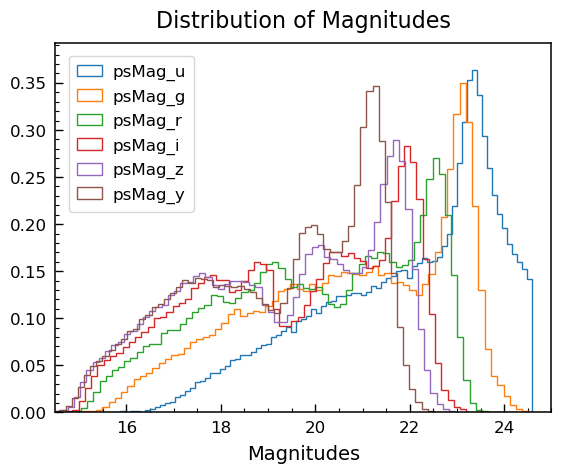

In [6]:
select_cols = ['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 
              'psMag_y']
for col in select_cols:
    _ = plt.hist(td_objects[col], histtype='step', label=col, 
                 bins='fd', density=True)
plt.legend(loc=2)
plt.xlim(14.5, 25)
plt.title('Distribution of Magnitudes')
plt.xlabel('Magnitudes')

##### 1.3.2 Show one density map for each class of `Qso`, `Gal`, `Star`

In [7]:
# groupby class
td_gp = td_objects.groupby('class')

# get the object_id for those having the largest number of epochs
qso_idx = td_gp.get_group('Qso').sort_values('lcN_r').index[-1]
gal_idx = td_gp.get_group('Gal').sort_values('lcN_r').index[-1]
star_idx = td_gp.get_group('Star').sort_values('lcN_r').index[-1]

# retrieve density maps for the above selected objects
qso_dm = np.load(os.path.join(dm_dir, f'{qso_idx}.npy'))
gal_dm = np.load(os.path.join(dm_dir, f'{gal_idx}.npy'))
star_dm = np.load(os.path.join(dm_dir, f'{star_idx}.npy'))

Text(0, 0.5, '$\\Delta\\, M$ [arb. unit]')

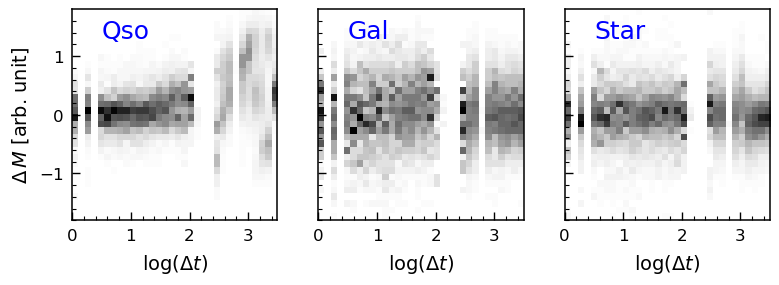

In [8]:
# show one representative density map for each class
fig, axes = plt.subplots(1,3, figsize=(9, 6), sharey=True)
cls_names = ['Qso', 'Gal', 'Star']
for i, dm in enumerate([qso_dm, gal_dm, star_dm]):
    axes[i].imshow(dm, cmap=plt.cm.Greys, extent=[0, 3.5, -1.8, 1.8])
    axes[i].text(0.5, 1.3, cls_names[i], c='blue')
    axes[i].set_xlabel('log($\Delta t$)')
    
axes[0].set_ylabel('$\Delta\, M$ [arb. unit]')

### 2. Train/Test on a subset with less than 30 epochs in the r-band light curve

#### 2.1 Import/Make dataset

In [8]:
# get objects with < 30 epochs & make three classes
low_cad_df = td_objects[(td_objects.lcN_r < 30)].copy()
low_cad_qso = low_cad_df[(low_cad_df['class'] == 'Qso') | (low_cad_df['class'] == 'Agn')]
low_cad_gal = low_cad_df[(low_cad_df['class'] == 'Gal')]
low_cad_star = low_cad_df[(low_cad_df['class'] == 'Star')]

print(f'number of objets for qso: {low_cad_qso.shape[0]}')
print(f'number of objets for gal: {low_cad_gal.shape[0]}')
print(f'number of objets for star: {low_cad_star.shape[0]}')

# update object class and merge
low_cad_df.loc[low_cad_qso.index, ['class']] = 0
low_cad_df.loc[low_cad_gal.index, ['class']] = 1
low_cad_df.loc[low_cad_star.index, ['class']] = 2

number of objets for qso: 2018
number of objets for gal: 23472
number of objets for star: 3013


In [9]:
# get labels, object_ids
low_cad_labels = low_cad_df['class'].values
low_cad_IDs = low_cad_df.index.values

##### Read-in Density Maps

In [10]:
%%time
# import density maps from disk
low_cad_rt = []
for idx in low_cad_df.index.values:
    r = np.load(os.path.join(dm_dir, f'{idx}.npy'))
    low_cad_rt.append(r)
    
low_cad_imgs = np.array(low_cad_rt)
low_cad_imgs.shape

CPU times: user 15.1 s, sys: 3.74 s, total: 18.8 s
Wall time: 30.7 s


(28503, 32, 32)

##### Select features from the object table

In [11]:
# gather column names
cls_color_cols = [col for col in td_objects.columns 
                    if ('stdColor' in col) & ('Err' not in col)]

# lcNonPeriodic columns
lc_NP_index = [9, 13, 15, 19, 20, 22, 25, 26]
cls_lc_cols = []
for idx in lc_NP_index:
    cls_lc_cols += [col for col in td_objects.columns 
                    if f'lcNonPeriodic[{idx}]' in col]

feats_cols = cls_color_cols + cls_lc_cols
low_cat_feats = low_cad_df[feats_cols].copy()

# add proper motion
pm = np.log10(np.sqrt(low_cad_df['psPm_ra']**2 + low_cad_df['psPm_dec']**2))
pm.name = 'pm'

low_cat_feats = low_cat_feats.join(pm, how='left')

# fill nan
low_cat_feats = low_cat_feats.fillna(0)
low_cat_feats.head(2)

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,lcNonPeriodic[9]_u,lcNonPeriodic[9]_g,lcNonPeriodic[9]_r,lcNonPeriodic[9]_i,lcNonPeriodic[9]_z,...,lcNonPeriodic[25]_g,lcNonPeriodic[25]_r,lcNonPeriodic[25]_i,lcNonPeriodic[25]_z,lcNonPeriodic[26]_u,lcNonPeriodic[26]_g,lcNonPeriodic[26]_r,lcNonPeriodic[26]_i,lcNonPeriodic[26]_z,pm
objectId,,,,,,,,,,,,,,,,,,,,,
0271426,3.099503,1.633201,1.581568,0.681385,0.150648,0.621094,0.208942,0.038883,0.019703,0.043512,...,0.277087,0.191878,0.231798,0.245026,2.558572,2.096913,3.336219,2.625942,2.270041,1.175717
0271448,3.169953,1.389682,1.197146,0.524731,0.118682,0.327715,0.049665,0.030037,0.005587,0.020151,...,0.194610,0.314757,0.199073,0.182002,2.310799,1.536574,1.573642,1.965158,2.083990,1.209478


#### 2.2 Create Model -> Train/Test

##### Train/Test split

In [12]:
# train/test split
low_cad_labels = low_cad_labels.astype(str).astype(int) # change dtype from object -> int
(train_images, test_images, train_labels, test_labels, train_ids, 
 test_ids) = train_test_split(low_cad_imgs, low_cad_labels, low_cad_IDs, 
                              test_size=0.3, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# add channel dim
train_images = train_images[:, :, :, np.newaxis]
test_images = test_images[:, :, :, np.newaxis]

# train/test split for other features
train_feats = low_cat_feats.loc[train_ids].values
test_feats = low_cat_feats.loc[test_ids].values

##### Creat TF DNN Model

In [66]:
# CNN layers
dm_input = tf.keras.Input(shape=(32, 32, 1), name='dm_input')
cnn_x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), 
                  dilation_rate=(2, 2))(dm_input)
cnn_x = layers.AveragePooling2D((2, 2))(cnn_x)
cnn_x = layers.Conv2D(64, (3, 3), activation='relu')(cnn_x)
cnn_x = layers.MaxPooling2D((2, 2))(cnn_x)
cnn_x = layers.Conv2D(64, (3, 3), activation='relu')(cnn_x)

# CNN Dense layers
cnn_x = layers.Flatten()(cnn_x)
cnn_x = layers.Dense(64, activation='relu')(cnn_x)

# tabular data dense layers
tb_input = tf.keras.Input(shape=(train_feats.shape[1],), name='tb_input')

# combine cnn features with tb features
x = layers.concatenate([cnn_x, tb_input])

# final dense layer
x = layers.Dense(64, activation='relu', use_bias=True)(x)
output = layers.Dense(3)(x)

# create the final model
full_model = tf.keras.Model(
    inputs = [dm_input, tb_input],
    outputs = output,
    name='full'
)

In [68]:
# compile
full_model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

##### Train -> Plot Progress

In [69]:
# train
history = full_model.fit(
    {'dm_input':train_images, 'tb_input':train_feats}, 
    train_labels, 
    epochs=15, validation_split=0.2, workers=16
)

Epoch 1/15
499/499 [==============================] - 42s 85ms/step - loss: 0.2496 - accuracy: 0.9294 - val_loss: 0.1774 - val_accuracy: 0.9521
Epoch 2/15
499/499 [==============================] - 2s 4ms/step - loss: 0.1542 - accuracy: 0.9575 - val_loss: 0.1572 - val_accuracy: 0.9557
Epoch 3/15
499/499 [==============================] - 2s 4ms/step - loss: 0.1330 - accuracy: 0.9619 - val_loss: 0.1512 - val_accuracy: 0.9577
Epoch 4/15
499/499 [==============================] - 2s 4ms/step - loss: 0.1270 - accuracy: 0.9652 - val_loss: 0.1462 - val_accuracy: 0.9604
Epoch 5/15
499/499 [==============================] - 2s 3ms/step - loss: 0.1201 - accuracy: 0.9668 - val_loss: 0.1399 - val_accuracy: 0.9622
Epoch 6/15
499/499 [==============================] - 1s 3ms/step - loss: 0.1214 - accuracy: 0.9659 - val_loss: 0.1309 - val_accuracy: 0.9644
Epoch 7/15
499/499 [==============================] - 1s 3ms/step - loss: 0.1108 - accuracy: 0.9685 - val_loss: 0.1338 - val_accuracy: 0.9652
Epoc

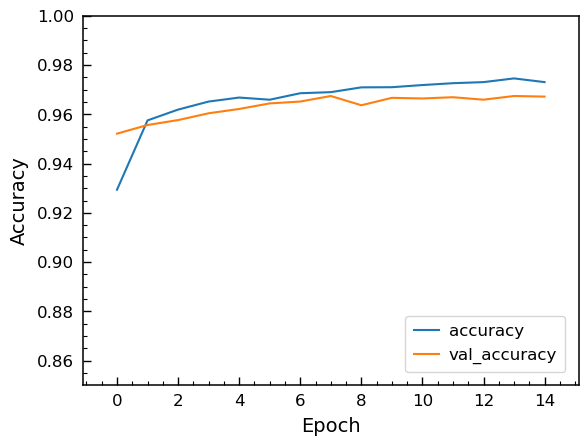

In [71]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

#####  Test on Test set -> Plot Confusion Matrix

In [72]:
# print test accuracy
test_loss, test_acc = full_model.evaluate(
    {'dm_input':test_images, 'tb_input':test_feats}, test_labels, verbose=2
)

268/268 - 13s - loss: 0.0977 - accuracy: 0.9724


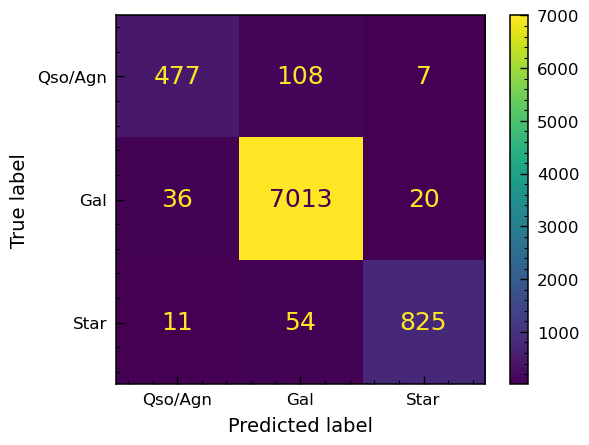

In [73]:
## ------------Confusion Matrix------------
# pred
test_pred = full_model.predict({'dm_input':test_images, 'tb_input':test_feats})
test_pred = np.argmax(test_pred, axis=1)

# make cf
cf = confusion_matrix(test_labels, test_pred)
ConfusionMatrixDisplay(cf, display_labels=['Qso/Agn', 'Gal', 'Star']).plot()

### 3 Train/Test on a random subset (20\% of the entire dataset)

#### 3.1 Import/Make dataset

In [24]:
# select every 5
h_cad_df = td_objects.iloc[::5].copy() 
h_cad_qso = h_cad_df[(h_cad_df['class'] == 'Qso') | (h_cad_df['class'] == 'Agn')]
h_cad_gal = h_cad_df[(h_cad_df['class'] == 'Gal')]
h_cad_star = h_cad_df[(h_cad_df['class'] == 'Star')]

print(f'number of objets for qso: {h_cad_qso.shape[0]}')
print(f'number of objets for gal: {h_cad_gal.shape[0]}')
print(f'number of objets for star: {h_cad_star.shape[0]}')

# update object class and merge
h_cad_df.loc[h_cad_qso.index, ['class']] = 0
h_cad_df.loc[h_cad_gal.index, ['class']] = 1
h_cad_df.loc[h_cad_star.index, ['class']] = 2

number of objets for qso: 6380
number of objets for gal: 10487
number of objets for star: 13521


In [25]:
# take out labels, IDs
h_cad_labels = h_cad_df['class'].values
h_cad_IDs = h_cad_df.index.values

##### Read-in Density Maps

In [26]:
%%time
h_cad_rt = []
for idx in h_cad_df.index.values:
    r = np.load(os.path.join(dm_dir, f'{idx}.npy'))
    h_cad_rt.append(r)
    
h_cad_imgs = np.array(h_cad_rt)
h_cad_imgs.shape

CPU times: user 15.9 s, sys: 4.41 s, total: 20.3 s
Wall time: 32.4 s


(30388, 32, 32)

##### Select tabular features from the object table

In [27]:
# gather column names
cls_color_cols = [col for col in td_objects.columns 
                    if ('stdColor' in col) & ('Err' not in col)]

# lc Non Periodic columns
lc_NP_index = [9, 13, 15, 19, 20, 22, 25, 26]
cls_lc_cols = []
for idx in lc_NP_index:
    cls_lc_cols += [col for col in td_objects.columns 
                    if f'lcNonPeriodic[{idx}]' in col]

feats_cols = cls_color_cols + cls_lc_cols
h_cad_feats = h_cad_df[feats_cols].copy()

# add proper motion
pm = np.log10(np.sqrt(h_cad_df['psPm_ra']**2 + h_cad_df['psPm_dec']**2))
pm.name = 'pm'

h_cad_feats = h_cad_feats.join(pm, how='left')

# fill nan
h_cad_feats = h_cad_feats.fillna(0)
h_cad_feats.head(2)

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,lcNonPeriodic[9]_u,lcNonPeriodic[9]_g,lcNonPeriodic[9]_r,lcNonPeriodic[9]_i,lcNonPeriodic[9]_z,...,lcNonPeriodic[25]_g,lcNonPeriodic[25]_r,lcNonPeriodic[25]_i,lcNonPeriodic[25]_z,lcNonPeriodic[26]_u,lcNonPeriodic[26]_g,lcNonPeriodic[26]_r,lcNonPeriodic[26]_i,lcNonPeriodic[26]_z,pm
objectId,,,,,,,,,,,,,,,,,,,,,
0271390,1.318985,0.514469,0.154915,0.077669,-0.01227,0.049787,0.015057,0.011363,0.013417,0.018822,...,0.188643,0.171811,0.141249,0.147907,1.258739,1.690556,1.657900,2.058601,2.193501,1.192828
0271397,2.523612,1.396339,1.012135,0.453517,0.10102,0.382448,0.033416,0.011757,0.018448,0.020207,...,0.189720,0.158178,0.179047,0.231473,2.170511,1.989821,2.172663,1.625595,1.857419,1.066813


#### 3.2 Create Model -> Train/Test

##### Train/Test split

In [28]:
# train/test split
h_cad_labels = h_cad_labels.astype(int) # change dtype from object -> int
(train_images, test_images, train_labels, test_labels, train_ids, 
 test_ids) = train_test_split(h_cad_imgs, h_cad_labels, h_cad_IDs, 
                              test_size=0.3, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# add channel dim
train_images = train_images[:, :, :, np.newaxis]
test_images = test_images[:, :, :, np.newaxis]

# train/test split for other features
train_feats = h_cad_feats.loc[train_ids].values
test_feats = h_cad_feats.loc[test_ids].values

##### Creat TF DNN Model

In [42]:
# CNN layers
dm_input = tf.keras.Input(shape=(32, 32, 1), name='dm_input')
cnn_x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), 
                  dilation_rate=(2, 2))(dm_input)
cnn_x = layers.AveragePooling2D((2, 2))(cnn_x)
cnn_x = layers.Conv2D(64, (3, 3), activation='relu')(cnn_x)
cnn_x = layers.MaxPooling2D((2, 2))(cnn_x)
cnn_x = layers.Conv2D(64, (3, 3), activation='relu')(cnn_x)

# CNN Dense layers
cnn_x = layers.Flatten()(cnn_x)
cnn_x = layers.Dense(64, activation='relu')(cnn_x)

# tabular dense layers
tb_input = tf.keras.Input(shape=(train_feats.shape[1],), name='tb_input')

# combine cnn features with tb features
x = layers.concatenate([cnn_x, tb_input])

# final dense layer
x = layers.Dense(64, activation='relu', use_bias=True)(x)
output = layers.Dense(3)(x)

# create model
full_model = tf.keras.Model(
    inputs = [dm_input, tb_input],
    outputs = output,
    name='full'
)

In [43]:
# compile
full_model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

##### Train -> Plot Progress

In [44]:
# train
history = full_model.fit(
    {'dm_input':train_images, 'tb_input':train_feats}, 
    train_labels, 
    epochs=15, validation_split=0.2, workers=16
)

Epoch 1/15
532/532 [==============================] - 54s 101ms/step - loss: 0.2987 - accuracy: 0.9163 - val_loss: 0.1582 - val_accuracy: 0.9438
Epoch 2/15
532/532 [==============================] - 2s 4ms/step - loss: 0.1539 - accuracy: 0.9581 - val_loss: 0.1646 - val_accuracy: 0.9598
Epoch 3/15
532/532 [==============================] - 1s 3ms/step - loss: 0.1496 - accuracy: 0.9619 - val_loss: 0.1295 - val_accuracy: 0.9636
Epoch 4/15
532/532 [==============================] - 2s 3ms/step - loss: 0.1356 - accuracy: 0.9643 - val_loss: 0.1065 - val_accuracy: 0.9706
Epoch 5/15
532/532 [==============================] - 2s 3ms/step - loss: 0.1406 - accuracy: 0.9646 - val_loss: 0.1416 - val_accuracy: 0.9603
Epoch 6/15
532/532 [==============================] - 1s 3ms/step - loss: 0.1324 - accuracy: 0.9678 - val_loss: 0.1039 - val_accuracy: 0.9704
Epoch 7/15
532/532 [==============================] - 1s 3ms/step - loss: 0.1047 - accuracy: 0.9698 - val_loss: 0.1067 - val_accuracy: 0.9709
Epo

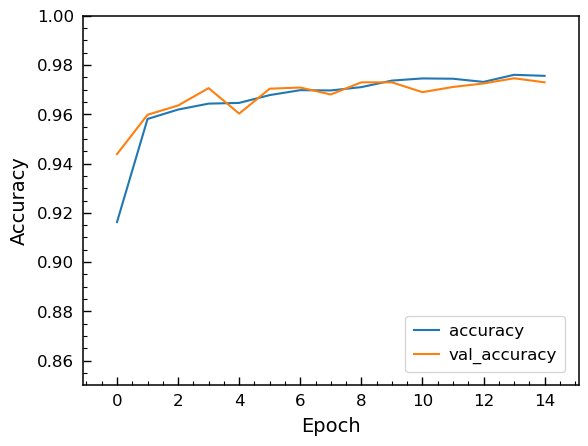

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

#####  Test on Test set -> Plot Confusion Matrix

In [46]:
# print test accuracy
test_loss, test_acc = full_model.evaluate(
    {'dm_input':test_images, 'tb_input':test_feats}, test_labels, verbose=2
)

285/285 - 1s - loss: 0.1197 - accuracy: 0.9739


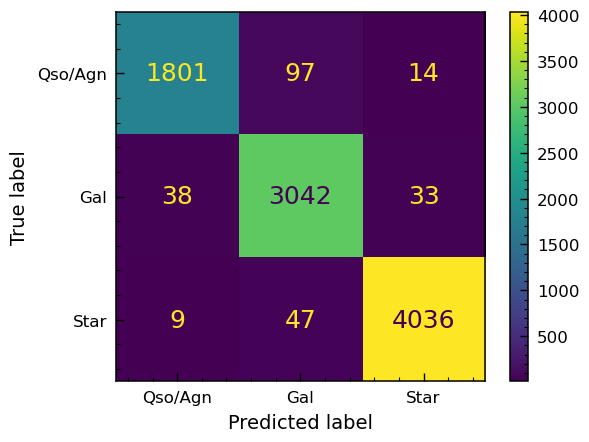

In [47]:
## ------------Confusion Matrix------------
# pred
test_pred = full_model.predict({'dm_input':test_images, 'tb_input':test_feats})
test_pred = np.argmax(test_pred, axis=1)

# make cf
cf = confusion_matrix(test_labels, test_pred)
ConfusionMatrixDisplay(cf, display_labels=['Qso/Agn', 'Gal', 'Star']).plot()

### => WY: Test on blinded dataset <=
### 4. Load Pre-trained and test on blinded dataset
Below are the steps that need to be taken:
1. Remove objects that do not satisfy the requirement as stated as the beginning (remove NaN)
2. Import density maps and make features
3. Load pre-trained model as provided
4. Test on the blinded dataset

#### 4.1 Read the blinded dataset

In [5]:
# read blinded dataset
blinded_df_og = pd.read_parquet(os.path.join(data_dir, 'ObjectTable_Blinded.parquet'))

## -----Clean Data-----
# select the objects that have time domain data
lc_cols = [col for col in blinded_df_og.columns if 'Periodic' in col]
blinded_df = blinded_df_og.dropna(subset=lc_cols, how='all').copy()

# require having proper motion and color
color_cols = [col for col in blinded_df.columns 
              if ('stdColor' in col) & ('Err' not in col) & ('4' not in col)]
blinded_df = blinded_df.dropna(subset=['psPm_ra', 'psPm_dec']+color_cols, 
                               how='any')

# require only those having a label in ['Qso', 'Agn', 'Gal', 'Star']
blinded_df = blinded_df[blinded_df['class'].isin(
    ['Qso', 'Agn', 'Gal', 'Star'])].copy()

blinded_df = blinded_df.join(lcN_r, how='left')

print(f'Total number of useable objects: {blinded_df.shape[0]}')
print('Counts for each class: ')
blinded_df['class'].value_counts()

Total number of useable objects: 17453
Counts for each class: 


Gal     9893
Qso     5934
Star    1590
Agn       36
Name: class, dtype: int64

#### 4.2 Import density maps and make feature array

In [7]:
# import density maps from disk
blinded_rt = []
for idx in blinded_df.index.values:
    r = np.load(os.path.join(dm_dir, f'{idx}.npy'))
    blinded_rt.append(r)
    
blinded_imgs = np.array(blinded_rt)
blinded_imgs.shape

(17453, 32, 32)

##### Other features

In [8]:
# gather column names
cls_color_cols = [col for col in blinded_df.columns 
                    if ('stdColor' in col) & ('Err' not in col)]

# lc Non Periodic columns
lc_NP_index = [9, 13, 15, 19, 20, 22, 25, 26]
cls_lc_cols = []
for idx in lc_NP_index:
    cls_lc_cols += [col for col in blinded_df.columns 
                    if f'lcNonPeriodic[{idx}]' in col]

feats_cols = cls_color_cols + cls_lc_cols
blinded_feats = blinded_df[feats_cols].copy()

# add proper motion
pm = np.log10(np.sqrt(blinded_df['psPm_ra']**2 + blinded_df['psPm_dec']**2))
pm.name = 'pm'

blinded_feats = blinded_feats.join(pm, how='left')

# fill nan
blinded_feats = blinded_feats.fillna(0)
blinded_feats.head(2)

,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,lcNonPeriodic[9]_u,lcNonPeriodic[9]_g,lcNonPeriodic[9]_r,lcNonPeriodic[9]_i,lcNonPeriodic[9]_z,...,lcNonPeriodic[25]_g,lcNonPeriodic[25]_r,lcNonPeriodic[25]_i,lcNonPeriodic[25]_z,lcNonPeriodic[26]_u,lcNonPeriodic[26]_g,lcNonPeriodic[26]_r,lcNonPeriodic[26]_i,lcNonPeriodic[26]_z,pm
objectId,,,,,,,,,,,,,,,,,,,,,
0271518,1.902520,0.765320,0.258804,0.117029,0.137209,0.236822,0.025739,0.034760,0.041333,0.066537,...,0.151992,0.188360,0.172366,0.165983,2.258671,1.949031,2.034430,1.727948,1.874601,1.145322
0271533,1.109498,0.036849,-0.062246,-0.046278,-0.078764,0.094176,0.036093,0.024445,0.025993,0.082291,...,0.166757,0.126121,0.204980,0.136425,2.005287,2.160760,2.167559,1.781991,2.218084,0.528019


#### 4.3 Load Pre-trained Model

In [9]:
full_model = tf.keras.models.load_model('full_model.h5')
full_model.summary()

Model: "full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dm_input (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         dm_input[0][0]                   
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 64)   18496       average_pooling2d[0][0]          
_______________________________________________________________________________________________

#### 4.4 Test on the blinded dataset

In [11]:
blinded_imgs = blinded_imgs[:, :, :, np.newaxis]/255.0
blinded_feats = blinded_feats.values

In [12]:
# replace class str with int
blinded_df = blinded_df.replace({'class': {'Star': 2, 'Gal': 1, 'Qso': 0, 'Agn': 0}})

# get labels, object_ids
b_labels = blinded_df['class'].values.astype(str).astype(int)

In [13]:
# make prediction
b_pred = full_model.predict({'dm_input':blinded_imgs, 'tb_input':blinded_feats})
b_pred_labels = np.argmax(b_pred, axis=1)

##### **Prediction Loss/Accuray**

In [14]:
# print test loss
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
b_loss = loss_func(b_labels, b_pred).numpy()

# print test accuracy
acc_func = tf.keras.metrics.SparseCategoricalAccuracy()
acc_func.update_state(b_labels, b_pred);
b_acc = acc_func.result().numpy()

print(f'loss: {b_loss:.4f} - accuracy: {b_acc:.4f}')

loss: 0.0871 - accuracy: 0.9735


##### **Make a confusion matrix**

Text(0.5, 1.0, 'Normalized by predicted labels (purity)')

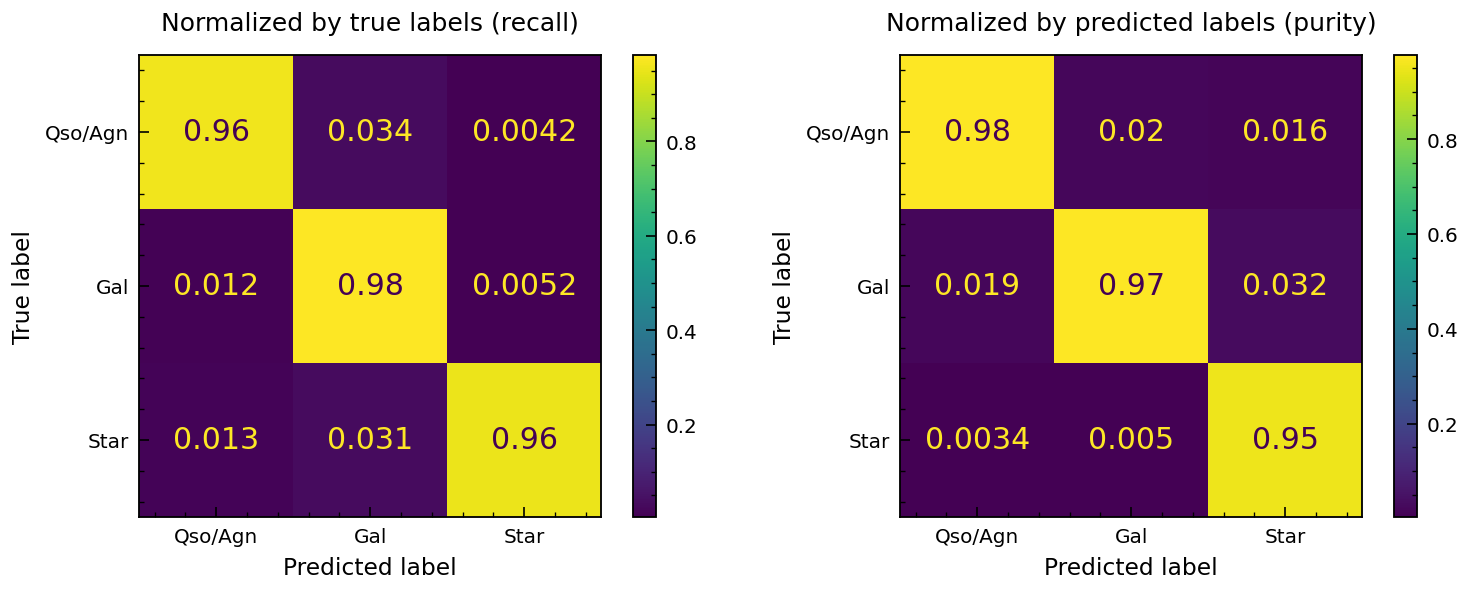

In [20]:
# make plots    
fig, axes = plt.subplots(1, 2, dpi=120, figsize=(15, 5))

str_labels = ['Qso/Agn', 'Gal', 'Star']
cf_n_t = confusion_matrix(b_labels, b_pred_labels, normalize='true')
cf_n_p = confusion_matrix(b_labels, b_pred_labels, normalize='pred')
ConfusionMatrixDisplay(cf_n_t, display_labels=str_labels).plot(ax=axes[0])
ConfusionMatrixDisplay(cf_n_p, display_labels=str_labels).plot(ax=axes[1])    
axes[0].set_title('Normalized by true labels (recall)', pad=15, fontsize=15)
axes[1].set_title('Normalized by predicted labels (purity)', pad=15, fontsize=15)